# Linear Regression

In [1]:
# ======= Libraries =======
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.linalg import expm, qr
import copy

# ======= Function definitions =======

def generate_problem(p, n, lstsq=False):
    X = np.random.randn(n, p)

    # Model definition
    theta_clean = np.ones(p)
    y = X @ theta_clean + 1e-1*np.random.randn(n) # right-hand side
    theta_0 = np.random.randn(p)

    if lstsq == True:
        theta_lstsq = np.linalg.lstsq(X,y)[0]
        return X, theta_0, y, theta_lstsq
    else:
        return X, theta_0, y

def solve_local_problem(Q,R, theta_0, y_batch, h, n):
    R_it = np.linalg.inv(R.T)
    exp_m = expm(-1/n* R @ R.T*h)
    return Q @ ( exp_m @ (Q.T @ theta_0 - R_it @ y_batch )) + Q @ (R_it @ y_batch) + theta_0 - Q @ (Q.T @ theta_0)

def solve_local_problem_b_1(x, theta_0, y, h, n):
    x = x.T
    norm = x.T @ x
    return theta_0 + (1 - np.exp(-norm*h/n))*(y - x.T @ theta_0)/norm*x

def loss(X, theta, y):
    n, p = X.shape
    return 1/n*np.linalg.norm(X @ theta - y)**2

def gradient(X, theta, y):
    n, p = X.shape
    return 1/n* X.T @ (X @ theta - y)

def make_SGD_step(X_batch, theta_0, y_batch, h):
    theta = theta_0 - h*gradient(X_batch, theta_0, y_batch)
    return theta

def relative_error(theta, thetalstsq=0):
    p = len(theta)
    if np.linalg.norm(thetalstsq) != 0:
        return(np.linalg.norm(theta - thetalstsq)/np.linalg.norm(thetalstsq))
    else:
        return(np.linalg.norm(theta - np.ones(p))/np.linalg.norm(np.ones(p)))

# ======= Problem generation =======

hs = np.logspace(-2, -1, 12)
p = 2000
n = 10000
N = 200
b = 50
n_max_iter = 2000
epsilon = 0.05
n_experiments = 30

X, theta_0, y, theta_lstsq = generate_problem(p,n, lstsq=True)

Xs = np.zeros((N, b, p))
ys = np.zeros((N, b))
Qs = np.zeros((N, p, b))
Rs = np.zeros((N, b, b))

for i_batch in range(N):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('QR finished')

# ======= Solving problem =======

steps_spl_meta = np.zeros((n_experiments, len(hs)))
steps_sgd_meta = np.zeros((n_experiments, len(hs)))
times_spl_meta = np.zeros((n_experiments, len(hs)))
times_sgd_meta = np.zeros((n_experiments, len(hs)))

for experiment in range(n_experiments):
    print('💩 Experiment {}/{}'.format(experiment+1, n_experiments))
    theta_0 = np.random.randn(p)
    steps_spl = []
    steps_sgd = []
    times_spl = []
    times_sgd = []
    for h in hs:
        # Splitting
        theta = copy.deepcopy(theta_0)
        n_iter = 0
        start_time = time.time()
        while relative_error(theta) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            theta = solve_local_problem(Qs[i], Rs[i], theta, ys[i], h*N, n)
            n_iter += 1
        end_time = time.time()
        times_spl.append(end_time-start_time)
        steps_spl.append(n_iter)
        

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Relative error {:.2f}'.format(relative_error(theta)))
        else:
            print('GGWP, splitting on {} with {} iters'.format(h, n_iter))
        

        # SGD
        theta = copy.deepcopy(theta_0)
        n_iter = 0
        start_time = time.time()
        while relative_error(theta) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            theta = make_SGD_step(Xs[i], theta, ys[i], h)
            if relative_error(theta) == float('Inf'):
                n_iter = n_max_iter
            n_iter += 1
        end_time = time.time()
        times_sgd.append(end_time-start_time)   
        if n_iter == n_max_iter+1:
            times_sgd[-1] = 10
        steps_sgd.append(n_iter)

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Relative error {:.2f}'.format(relative_error(theta)))
        else:
            print('GGWP, SGD on {} with {} iters'.format(h, n_iter))

    steps_spl_meta[experiment, :] = steps_spl
    steps_sgd_meta[experiment, :] = steps_sgd
    times_spl_meta[experiment, :] = times_spl
    times_sgd_meta[experiment, :] = times_sgd

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


QR finished
💩 Experiment 0
GGWP, splitting on 0.01 with 657 iters
GGWP, SGD on 0.01 with 532 iters
GGWP, splitting on 0.012328467394420659 with 549 iters
GGWP, SGD on 0.012328467394420659 with 427 iters
GGWP, splitting on 0.01519911082952934 with 465 iters
GGWP, SGD on 0.01519911082952934 with 351 iters
GGWP, splitting on 0.01873817422860384 with 399 iters
GGWP, SGD on 0.01873817422860384 with 302 iters
GGWP, splitting on 0.023101297000831605 with 353 iters
GGWP, SGD on 0.023101297000831605 with 279 iters
GGWP, splitting on 0.02848035868435802 with 319 iters
GGWP, SGD on 0.02848035868435802 with 284 iters
GGWP, splitting on 0.03511191734215131 with 298 iters
GGWP, SGD on 0.03511191734215131 with 343 iters
GGWP, splitting on 0.04328761281083057 with 285 iters
GGWP, SGD on 0.04328761281083057 with 689 iters
GGWP, splitting on 0.0533669923120631 with 277 iters
Limit of iteration is reached. Relative error 34904.61
GGWP, splitting on 0.06579332246575682 with 274 iters
Limit of iteration is

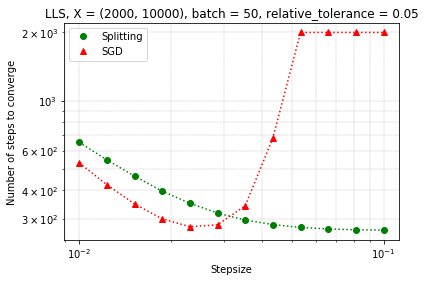

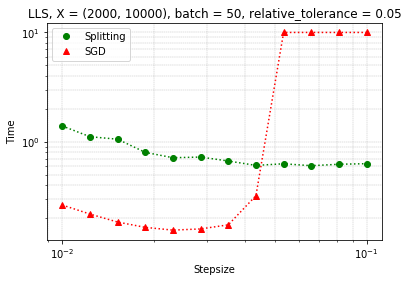

In [21]:
steps_spl = np.average(steps_spl_meta, axis = 0)  
steps_sgd = np.average(steps_sgd_meta, axis = 0) 
times_spl = np.average(times_spl_meta, axis = 0) 
times_sgd = np.average(times_sgd_meta, axis = 0) 

plt.figure(figsize=(6.0, 4.0))
plt.title('LLS, X = ({}, {}), batch = {}, relative_tolerance = {}'.format(p, n, b, epsilon))
plt.loglog(hs, steps_spl, 'go', label = 'Splitting')
plt.loglog(hs, steps_spl, 'g:')
plt.loglog(hs, steps_sgd, 'r^', label = 'SGD')
plt.loglog(hs, steps_sgd, 'r:')
plt.grid(True,which="both", linestyle='--', linewidth=0.4)
# plt.grid()
plt.xlabel('Stepsize')
plt.ylabel('Number of steps to converge')
plt.legend()

# plt.savefig('sgd_split_step_n{}.svg'.format(epsilon))
plt.savefig('sgd_split_time_lls.pdf')
plt.show()

plt.figure(figsize=(6.0, 4.0))
plt.title('LLS, X = ({}, {}), batch = {}, relative_tolerance = {}'.format(p, n, b, epsilon))
plt.loglog(hs, times_spl, 'go', label = 'Splitting')
plt.loglog(hs, times_spl, 'g:')
plt.loglog(hs, times_sgd, 'r^', label = 'SGD')
plt.loglog(hs, times_sgd, 'r:')
plt.grid(True,which="both", linestyle='--', linewidth=0.4)
plt.xlabel('Stepsize')
plt.ylabel('Time')
plt.legend()

# plt.savefig('sgd_split_step_t{}.svg'.format(epsilon))
plt.savefig('sgd_split_iterations_lls.pdf')
plt.show()

# Logistic regression

In [32]:
# ======= Libraries =======

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint
from scipy.linalg import expm, qr
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import copy

# ======= Function definitions =======

def sigmoid(x):
    return np.array([1/(1 + np.exp(-x_i)) for x_i in x])

def make_splitting_step(Q, R, theta_0, y, h, n):
    h_seq = [0, h]
    z_0 = Q.T@theta_0
    def rhs(z, t):
        lin_hyp = R.T @ z
        return -1/n * R@(sigmoid(lin_hyp) - y)
    z_h = odeint(rhs, z_0, h_seq)[-1]

    theta = Q@(z_h - z_0) + theta_0
    return theta

def loss_logreg(X, theta, y):
    h_theta = [1/(1+np.exp(-theta.T @ x)) for x in X]
    y_true = y
    y_pred = h_theta
    return log_loss(y_true, y_pred)

def generate_problem_logistic_regression():
    trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
    X_train = trainset.data.to(dtype=torch.float)/255
    y_train = trainset.targets
    X_train.resize_(len(X_train),  X_train[0].shape[0]*X_train[0].shape[1])
    y_train.view(-1).long()

    indicies0 = y_train == 0
    indicies1 = y_train == 1
    return X_train[indicies0 + indicies1], y_train[indicies0 + indicies1]

class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(p, 1)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

def loss_moving_average(loss, window=50):
    if loss == []:
        return 1000
    else:
        return(np.average(loss[-window:]))

# ======= Problem generation =======

p = 784
n = 12665
b = 128
N = n//b
n_max_iter = 4000
n_experiments = 30

epsilon = 0.33
hs = np.logspace(-2.5, 2.5, 15)

X, y = generate_problem_logistic_regression()
print('Data loaded')
theta_0 = np.random.randn(p)

model = LogisticRegression()
criterion = nn.BCELoss()
print('Model loaded')

Xs = np.zeros((N, b, p))
ys = np.zeros((N, b))
Qs = np.zeros((N, p, b))
Rs = np.zeros((N, b, b))

for i_batch in range(N):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('QR finished')
# ======= Solving problem =======
steps_spl_meta = np.zeros((n_experiments, len(hs)))
steps_sgd_meta = np.zeros((n_experiments, len(hs)))
times_spl_meta = np.zeros((n_experiments, len(hs)))
times_sgd_meta = np.zeros((n_experiments, len(hs)))

for experiment in range(n_experiments):
    print('💩 Experiment {}/{}'.format(experiment+1, n_experiments))
    theta_0 = np.random.randn(p)
    model = LogisticRegression()
    criterion = nn.BCELoss()
    steps_spl = []
    steps_sgd = []
    times_spl = []
    times_sgd = []
    for h in hs:
        losss_spl = []
        losss_sgd = []
        # Splitting
        theta = copy.deepcopy(theta_0)
        n_iter = 0
        start_time = time.time()
        while loss_moving_average(losss_spl) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            X_batch = Xs[i]
            y_batch = ys[i]
            loss = loss_logreg(X_batch, theta, y_batch)
            losss_spl.append(loss)

            theta = make_splitting_step(Qs[i], Rs[i], theta, y_batch, h*N, n)
            theta = np.squeeze(theta)
            n_iter += 1
        end_time = time.time()
        times_spl.append(end_time-start_time)
        steps_spl.append(n_iter)

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Average loss {:.2f}'.format(loss_moving_average(losss_spl)))
        else:
            print('GGWP, splitting on {} with {} iters'.format(h, n_iter))
        
        # SGD
        theta = copy.deepcopy(theta_0)
        model.train()
        for parameter in model.parameters():
            parameter.data[0] = torch.from_numpy(theta)
            break
        n_iter = 0
        start_time = time.time()
        while loss_moving_average(losss_sgd) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            X_batch = torch.from_numpy(Xs[i]).float()
            y_batch = torch.from_numpy(ys[i]).float()
            model.zero_grad()
            # Forward pass
            y_pred = model(X_batch)
            # Compute Loss
            loss = criterion(y_pred.view(-1), y_batch.view(-1))
            losss_sgd.append(loss.data)
            # Backward pass
            loss.backward()
            for parameter in model.parameters():
                parameter.data = parameter.data - h*parameter.grad.data
            if loss_moving_average(losss_sgd) == float('Inf'):
                n_iter = n_max_iter
            n_iter += 1
            # print(loss_moving_average(losss_sgd))
        end_time = time.time()
        times_sgd.append(end_time-start_time)
        if n_iter == n_max_iter+1:
            times_sgd[-1] = 1  
        steps_sgd.append(n_iter)

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Average loss {:.2f}'.format(loss_moving_average(losss_sgd)))
        else:
            print('GGWP, SGD on {} with {} iters'.format(h, n_iter))
    steps_spl_meta[experiment, :] = steps_spl
    steps_sgd_meta[experiment, :] = steps_sgd
    times_spl_meta[experiment, :] = times_spl
    times_sgd_meta[experiment, :] = times_sgd

Data loaded
Model loaded
QR finished
💩 Experiment 1/30
GGWP, splitting on 0.0031622776601683794 with 567 iters
GGWP, SGD on 0.0031622776601683794 with 565 iters
GGWP, splitting on 0.0071968567300115215 with 270 iters
GGWP, SGD on 0.0071968567300115215 with 263 iters
GGWP, splitting on 0.016378937069540647 with 133 iters
GGWP, SGD on 0.016378937069540647 with 133 iters
GGWP, splitting on 0.0372759372031494 with 76 iters
GGWP, SGD on 0.0372759372031494 with 75 iters
GGWP, splitting on 0.08483428982440722 with 55 iters
GGWP, SGD on 0.08483428982440722 with 54 iters
GGWP, splitting on 0.19306977288832505 with 43 iters
GGWP, SGD on 0.19306977288832505 with 37 iters
GGWP, splitting on 0.43939705607607904 with 23 iters
GGWP, SGD on 0.43939705607607904 with 18 iters
GGWP, splitting on 1.0 with 15 iters
GGWP, SGD on 1.0 with 12 iters
GGWP, splitting on 2.2758459260747887 with 12 iters
GGWP, SGD on 2.2758459260747887 with 16 iters
GGWP, splitting on 5.1794746792312125 with 11 iters
GGWP, SGD on 

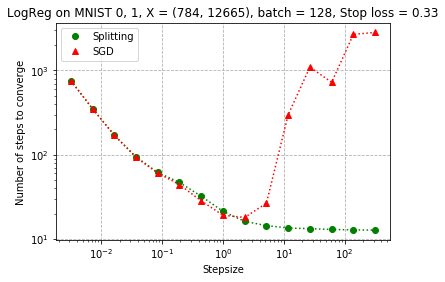

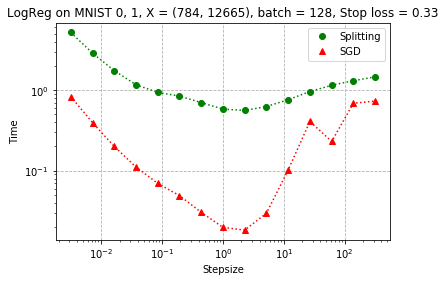

In [33]:
steps_spl = np.average(steps_spl_meta, axis = 0)  
steps_sgd = np.average(steps_sgd_meta, axis = 0) 
times_spl = np.average(times_spl_meta, axis = 0) 
times_sgd = np.average(times_sgd_meta, axis = 0) 

plt.figure(figsize=(6.0, 4.0))
plt.title('LogReg on MNIST 0, 1, X = ({}, {}), batch = {}, Stop loss = {}'.format(p, n, b, epsilon))
plt.loglog(hs, steps_spl, 'go', label = 'Splitting')
plt.loglog(hs, steps_spl, 'g:')
plt.loglog(hs, steps_sgd, 'r^', label = 'SGD')
plt.loglog(hs, steps_sgd, 'r:')
# plt.grid(True,which="both", linestyle='--', linewidth=0.4)
plt.grid(linestyle='--')
plt.xlabel('Stepsize')
plt.ylabel('Number of steps to converge')
plt.legend()

# plt.savefig('sgd_split_step_n{}.svg'.format(epsilon))
plt.savefig('sgd_split_time_logreg.pdf')
plt.show()

plt.figure(figsize=(6.0, 4.0))
plt.title('LogReg on MNIST 0, 1, X = ({}, {}), batch = {}, Stop loss = {}'.format(p, n, b, epsilon))
plt.loglog(hs, times_spl, 'go', label = 'Splitting')
plt.loglog(hs, times_spl, 'g:')
plt.loglog(hs, times_sgd, 'r^', label = 'SGD')
plt.loglog(hs, times_sgd, 'r:')
# plt.grid(True,which="both", linestyle='--', linewidth=0.4)
plt.grid(linestyle='--')
plt.xlabel('Stepsize')
plt.ylabel('Time')
plt.legend()

# plt.savefig('sgd_split_step_t{}.svg'.format(epsilon))
plt.savefig('sgd_split_iterations_logreg.pdf')
plt.show()

# Softmax regression

In [35]:
# ======= Libraries =======

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint
from scipy.linalg import expm, qr
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import copy
from tqdm import tqdm
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# ======= Function definitions =======
## ======= SPLITTING =======
def softmax(x):
    normalization = torch.sum(torch.exp(x))
    return torch.Tensor([np.exp(x_i)/normalization for x_i in x])

def sigmoid(X_batch, thetas):
    if len(X_batch.shape) > 1:
        batch_size, p = X_batch.shape
    else:
        X_batch = np.expand_dims(X_batch, axis=0)
        batch_size, p = X_batch.shape
    K = len(thetas) - 1
    h = np.zeros((batch_size, K))
    theta_b = thetas[-1]
    for i_object in range(batch_size):
        x = X_batch[i_object]
        etas = [np.float(thetas[k] @ x + theta_b[k]) for k in range(K)]
        normalization = np.sum(np.exp(etas))
        h[i_object, :] = np.exp(etas)/normalization
    return h

def make_splitting_step(thetas_0, Q, R, y_batch, n, h):
    Q, R = copy.deepcopy(Q), copy.deepcopy(R)
    batch_size      = len(y_batch)
    K = len(thetas_0)
    y_batch_one_hot = torch.zeros((batch_size, K))
    y_batch_one_hot[np.arange(batch_size), y_batch] = 1
    thetas_final = []
    h_seq = [0, h]

    # Biases update (Need to verify 🤔) Softmax does not depend on the bias
    # theta_b_0 = thetas_0[-1]
    # batch_softmax_matrix = [softmax(etas_0_point) for etas_0_point in etas_0] # batch_size x K
    # theta_b_final = theta_b_0 + h*1/n*(np.sum(batch_softmax_matrix, axis = 0) - np.sum(y_batch_one_hot, axis=0))

    # Weights update
    etas_0  = Q.T @ thetas_0[:K].T   # batch_size x K
    xi_0    = torch.flatten(etas_0, 0)
    def rhs_xi(xi_0, t, R, n, y_batch_one_hot):
        batch_size = R.size(0)
        K = int(len(xi_0) / batch_size)
        print(type(xi_0))
        etas = torch.split(xi_0, K)   # batch_size x K

        L_exp   = torch.exp(R @ etas) # batch_size x K
        L_norms = torch.sum(L_exp, 1) # batch_size

        xi_rhs = torch.zeros(batch_size*K)
        for i_class in range(K):
            labels_class        = y_batch_one_hot[:, i_class]
            predictions_class   = torch.div(L_exp[: i_class], L_norms)
            xi_rhs[i_class:(i_class+1)*batch_size] = -1/n * R @ (predictions_class - labels_class)
        return xi_rhs
    # -1 at the end stands for the vector's value at the last timestamp
    xi_h            = torch.Tensor(odeint(rhs_xi, xi_0.cpu(), h_seq, args=(R.cpu(), n, y_batch_one_hot.cpu()))[-1])
    etas_h          = torch.split(xi_h, K) 
    etas_h          = torch.stack(etas_h)
    thetas_final    = (Q @ (etas_h - etas_0)).T + thetas_0

    # for i_class in range(K):
    #     theta_class_0   = torch.Tensor(thetas_0[i_class])
    #     eta_class_0     = torch.Tensor(etas_0[:, i_class])
    #     labels_k        = y_batch_one_hot[:, i_class]
    #     def rhs(eta_0, t, etas_0, labels_class, i_class, R, n):
    #         etas_0[:, i_class] = torch.Tensor(eta_0)
    #         batch_softmax_matrix = [softmax(etas_0_point) for etas_0_point in etas_0] # batch_size x K
    #         softmax_class = torch.Tensor([row[i_class] for row in batch_softmax_matrix])
    #         return -1/n * R @ torch.Tensor(softmax_class - labels_class)
    #     # -1 at the end stands for the vector's value at the last timestamp
    #     eta_class_h = torch.Tensor(odeint(rhs, torch.Tensor(eta_class_0), h_seq, args=(etas_0, labels_k, i_class, R, n))[-1])
    #     theta_class_final = Q @ (eta_h - eta_0) + theta_0
    #     thetas_final.append(theta_class_final)
    
    # thetas_final = torch.stack(thetas_final)
  
    # We try to ignore bias term, since it doesn't affect inference
    # thetas_final.append(theta_b_final) 
    return thetas_final

def train_splitting(model, Qs, Rs, X_trains, y_trains, X_test, y_test, n_epochs, hs, weights_name = './'):
	# Initialization and recovering dimensionality
    model     = model.to(device)
    criterion = nn.CrossEntropyLoss()
    N_batches  = int(Rs.size(0))
    batch_size = int(Rs.size(1))
    K = torch.max(y_trains) + 1
    p = X_test.size(1)
    n = N_batches*batch_size
    thetas = []
    parameter_list = []
    for parameter in model.parameters():
        parameter_list.append(parameter.data.cpu())

    # Initial value of each parameter
    thetas = [parameter_list[0][i_class] for i_class in range(K)]
    thetas = torch.stack(thetas)
    theta_b = parameter_list[1]
    thetas, theta_b = thetas.to(device), theta_b.to(device)

    history = {}  
    history['train_loss'] = np.zeros(n_epochs)
    history['test_loss']  = np.zeros(n_epochs)
    history['train_acc']  = np.zeros(n_epochs)
    history['test_acc']   = np.zeros(n_epochs)

    for epoch in tqdm(range(n_epochs)):
        #==== Forward steps  ====
        model.train()
        h = hs[epoch]
        for i_batch in range(N_batches):
            # print('    🤖Working on the {}/{} batch'.format(i_batch+1, N_batches))
            # Forward pass
            images_q, images_r, images, labels  = Qs[i_batch], Rs[i_batch], X_trains[i_batch], y_trains[i_batch]
            images_q, images_r, images, labels  = images_q.to(device), images_r.to(device), images.to(device), labels.to(device)
            outputs                     		= model(X_trains[i_batch]) 

            # Splitting step
            model.zero_grad()
            thetas = make_splitting_step(thetas, images_q, images_r, labels, n, h*N_batches)         

        # Metrics calculation
        parameter_list = [thetas[:int(K)], theta_b]
        model = model_init(model, parameter_list).float()
        predictions = model(images)
        loss = criterion(predictions, labels)
        history['train_loss'][epoch] = loss.data
        pred_label = torch.max(predictions, 1, keepdim=True)[1]
        history['train_acc'][epoch] = pred_label.eq(labels.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(labels)
        with torch.no_grad():
            model.eval()
            Xst = X_test.to(device)
            yst = y_test.to(device)
            predictions = model(Xst)
            loss = criterion(predictions, yst)
            history['test_loss'][epoch] = loss.data
            pred_label = torch.max(predictions, 1, keepdim=True)[1]
            history['test_acc'][epoch] = pred_label.eq(yst.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(yst)
    return history

## ======= SGD =======

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(int(input_dim), int(output_dim))
    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        out = F.softmax(self.linear(x), dim=1)
        return out

def load_model(X_test, y_test):
    '''
    Returns logistic regression model
    Which is just single linear layer with flattening at the beginning and softmax at the end
    '''
    input_dim = X_test[0].numel()

    # Handling with usual and one-hot format
    if any(y_test > 1):
        output_dim = max(y_test) + 1
    else:
        output_dim = 2

    model = LogisticRegression(input_dim, output_dim)
    return model

def load_batched_data(batch_size=50, shuffle = True, qr_mode = False):
    '''
    Load batches of MNIST data.

    Output: X_trains - N_train batches of training data, 
            y_trains - N_train batches of labels,
            X_test - test points
            y_test - test labels
    X_trains: torch.array of shape (N_train,batch_size,*X_train[0].shape),
        where 
        N_train - the number of batches, 
        batch_size - batch size
        *X_train[0].shape - shape of the dataset point;

    y_trains: torch.array of shape (N_train,batch_size);

    X_test: torch.array of shape (s_test,*X_train[0].shape),
        where
        s_test - the number of test points;

    y_test: torch.array of shape (s_test);
    '''
    number_of_classes = 3
    trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
    X_train = trainset.data.to(dtype=torch.float)/255
    y_train = trainset.targets
    mask    = y_train <= number_of_classes
    X_train = X_train[mask]
    y_train = y_train[mask]
    X_train.resize_(len(X_train), *X_train[0].view(-1).shape)
    y_train.view(-1).long()

    if shuffle == True:
        shuffling = torch.randperm(len(y_train))
        X_train = X_train[shuffling]
        y_train = y_train[shuffling]

    # Download and load the test data
    testset = datasets.MNIST('./mnist_data/', download=True, train=False)
    X_test = testset.data.to(dtype=torch.float)/255
    y_test = testset.targets
    mask   = y_test <= number_of_classes
    X_test = X_test[mask]
    y_test = y_test[mask]
    X_test.resize_(len(X_test), *X_test[0].view(-1).shape)
    y_test.view(-1).long()

    if shuffle == True:
        shuffling = torch.randperm(len(y_test))
        X_test = X_test[shuffling].to(device)
        y_test = y_test[shuffling]

    s_train = len(y_train)
    s_test  = len(y_test)

    N_train = int(s_train/batch_size)   # Number of training batches

    X_trains    = torch.zeros((N_train, batch_size, *X_train[0].view(-1).shape), requires_grad=False).to(device)
    y_trains    = torch.zeros((N_train, batch_size), requires_grad=False, dtype=torch.int64).to(device)
    if qr_mode:
        Qs      = torch.zeros((N_train, *X_train[0].view(-1).shape, batch_size), requires_grad=False).to(device)
        Rs      = torch.zeros((N_train, batch_size, batch_size), requires_grad=False).to(device)
        print('🤖QR started')

    for i in range(N_train):
        X_trains[i] = X_train[batch_size*i:batch_size*(i+1), :]
        y_trains[i] = y_train[batch_size*i:batch_size*(i+1)]
        if qr_mode:
            Qs[i], Rs[i] = torch.qr(X_trains[i].T)      

    if qr_mode:
        print('✅QR computed')
        return X_trains, y_trains, X_test, y_test, Qs, Rs
    else:
        return X_trains, y_trains, X_test, y_test

def loss_moving_average(loss, window=50):
    if loss == []:
        return 1000
    else:
        return(np.average(loss[-window:]))

def train_SGD(model, X_trains, y_trains, X_test, y_test, n_epochs, hs, weights_name = './'):
    model     = model.to(device)
    criterion = nn.CrossEntropyLoss()
    N_batches  = int(X_trains.size(0))
    batch_size = int(X_trains.size(1)) 

    history = {}  
    history['train_loss'] = np.zeros(n_epochs)
    history['test_loss']  = np.zeros(n_epochs)
    history['train_acc']  = np.zeros(n_epochs)
    history['test_acc']   = np.zeros(n_epochs)

    for epoch in tqdm(range(n_epochs)):
        #==== Forward steps  ====
        model.train()
        h = hs[epoch]
        for i_batch in range(N_batches):
            # Forward pass
            images, labels = X_trains[i_batch], y_trains[i_batch]
            images, labels = images.to(device), labels.to(device)
            predictions = model(images)
            loss = criterion(predictions, labels)

            # Gradient step
            model.zero_grad()
            loss.backward()
            for idp, parameter in enumerate(model.parameters()):
                grad           = parameter.grad.data
                grad           = grad.to(device)
                parameter.data = parameter.data - h*grad

        # Metrics calculation
        history['train_loss'][epoch] = loss.data
        pred_label = torch.max(predictions, 1, keepdim=True)[1]
        history['train_acc'][epoch] = pred_label.eq(labels.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(labels)
        with torch.no_grad():
            model.eval()
            Xst = X_test.to(device)
            yst = y_test.to(device)
            predictions = model(Xst)
            loss = criterion(predictions, yst)
            history['test_loss'][epoch] = loss.data
            pred_label = torch.max(predictions, 1, keepdim=True)[1]
            history['test_acc'][epoch] = pred_label.eq(yst.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(yst)
    return history

def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)

def model_init(model, parameter_list):
    new_model = copy.deepcopy(model)
    for idp, parameter in enumerate(new_model.parameters()):
        parameter.data = torch.tensor(parameter_list[idp]).to(device)
    return new_model

def plot_histories(histories, titles, suptitle=''):
    fig = plt.figure(figsize = (16,9))
    fig.suptitle(suptitle)
    plt.subplot(2, 2, 1)
    plt.xlabel('epoch')
    plt.ylabel('Train loss')
    for history, title in zip(histories, titles):
        plt.semilogy(history['train_loss'], label = title)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.xlabel('epoch')
    plt.ylabel('Train accuracy')
    for history, title in zip(histories, titles):
        plt.plot(history['train_acc'], label = title)
    plt.legend()
 
    plt.subplot(2, 2, 3)
    plt.xlabel('epoch')
    plt.ylabel('Test loss')
    for history, title in zip(histories, titles):
        plt.semilogy(history['test_loss'], label = title)
    plt.legend()
 
    plt.subplot(2, 2, 4)
    plt.xlabel('epoch')
    plt.ylabel('Test accuracy')
    for history, title in zip(histories, titles):
        plt.plot(history['test_acc'], label = title)
    plt.legend()
 
    plt.savefig('history {}.pdf'.format(suptitle))
    plt.show()

# ======= Problem generation =======

batch_size = 256
X_trains, y_trains, X_test, y_test, Qs, Rs = load_batched_data(batch_size=batch_size, qr_mode = True)
print('🐱Data loaded')

N_batches = int(len(y_trains)/batch_size)
n_epochs = 5
h = 0.1
hs_sgd = [h for i in range(n_epochs)]
model = load_model(X_test, y_test)
print('🐱Model loaded')

parameter_list_init = []
for parameter in model.parameters():
    parameter_list_init.append(parameter)

# ======= Solving problem =======
model = model_init(model, parameter_list_init)
print('🐱Model Initialized')

print('🤖SGD started')
history_sgd = train_SGD(model, X_trains, y_trains, X_test, y_test, n_epochs, hs)
print('✅SGD finished')

model = model_init(model, parameter_list_init)
print('🐱Model Initialized')

print('🤖Splitting started')
history_spl = train_splitting(model, Qs, Rs, X_trains, y_trains, X_test, y_test, n_epochs, hs, weights_name = './')
print('✅Splitting finished')

🤖QR started


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:321: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 40%|████      | 2/5 [00:00<00:00, 17.07it/s]

✅QR computed
🐱Data loaded
🐱Model loaded
🐱Model Initialized
🤖SGD started


  0%|          | 0/5 [00:00<?, ?it/s]

✅SGD finished
🐱Model Initialized
🤖Splitting started
<class 'numpy.ndarray'>


AttributeError: ignored

In [0]:
plot_histories([history_sgd, history_spl], ['SGD','Splitting'], 'Softmax regression on MNIST, 3 classes')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 5/5 [00:38<00:00,  7.76s/it]


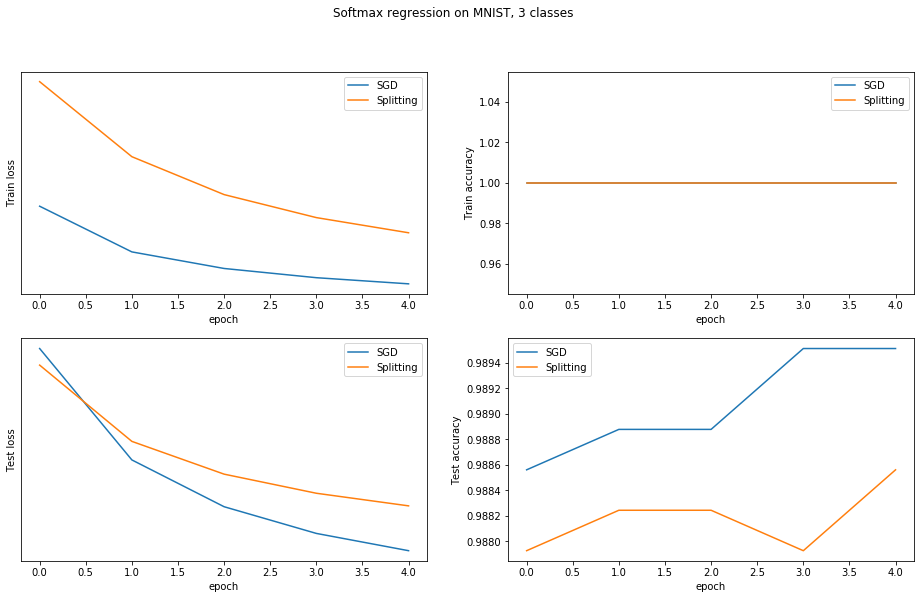

In [0]:
plot_histories([history_sgd, history], ['SGD','Splitting'], 'Softmax regression on MNIST, 3 classes')

In [0]:
# TRASH

		

    etas_0 = [Q.T @ thetas_0[i] for i in range(K)]
	etas
    def rhs(etas, t, X_batch, y_batch, thetas, r, n):
        batch_size = len(y_batch)
        y_batch_one_hot = np.zeros((batch_size, K))
        y_batch_one_hot[np.arange(batch_size), y_batch] = 1
        etas    = np.array(etas)
        vector  = np.exp(etas*r)
        normalization = np.sum(vector)
        return np.squeeze(-1/n * r * (sigmoid(X_batch, thetas) - y_batch_one_hot))

    eta = odeint(rhs, etas_0, h_seq, args=(X_batch, y_batch, thetas_0, r, n))[-1]

    for i_parameter in range(K):
        theta_0 = thetas_0[i_parameter]
        eta_0 = etas_0[i_parameter]
        theta_final = q *(eta[i_parameter] - eta_0) + theta_0
        thetas_final.append(theta_final)
    theta_b_0 = thetas_0[-1]
    batch_size = len(y_batch)
    y_batch_one_hot = np.zeros((batch_size, K))
    y_batch_one_hot[np.arange(batch_size), y_batch] = 1
    theta_b = np.squeeze(theta_b_0 -1/n * (sigmoid(X_batch, thetas_0) - y_batch_one_hot)*h)
    thetas_final.append(theta_b)
    return thetas_final

# Softmax regression revisited

In [0]:
# ======= Libraries =======

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint
from scipy.linalg import expm, qr
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import copy
from tqdm import tqdm
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# ======= Function definitions =======
## ======= SPLITTING =======
def softmax(x):
    normalization = torch.sum(torch.exp(x))
    return torch.Tensor([np.exp(x_i)/normalization for x_i in x])

def sigmoid(X_batch, thetas):
    if len(X_batch.shape) > 1:
        batch_size, p = X_batch.shape
    else:
        X_batch = np.expand_dims(X_batch, axis=0)
        batch_size, p = X_batch.shape
    K = len(thetas) - 1
    h = np.zeros((batch_size, K))
    theta_b = thetas[-1]
    for i_object in range(batch_size):
        x = X_batch[i_object]
        etas = [np.float(thetas[k] @ x + theta_b[k]) for k in range(K)]
        normalization = np.sum(np.exp(etas))
        h[i_object, :] = np.exp(etas)/normalization
    return h

def make_splitting_step(thetas_0, Q, R, y_batch, n, h):
    Q, R = copy.deepcopy(Q), copy.deepcopy(R)
    batch_size      = len(y_batch)
    K = len(thetas_0)
    y_batch_one_hot = torch.zeros((batch_size, K))
    y_batch_one_hot[np.arange(batch_size), y_batch] = 1
    thetas_final = []
    h_seq = [0, h]

    # Biases update (Need to verify 🤔) Softmax does not depend on the bias
    # theta_b_0 = thetas_0[-1]
    # batch_softmax_matrix = [softmax(etas_0_point) for etas_0_point in etas_0] # batch_size x K
    # theta_b_final = theta_b_0 + h*1/n*(np.sum(batch_softmax_matrix, axis = 0) - np.sum(y_batch_one_hot, axis=0))

    # Weights update
    etas_0 = torch.Tensor(Q.T @ thetas_0[:K].T)   # batch_size x K
    xi_0    = torch.flatten(etas_0, 0)
    def rhs_xi(xi_0, t, R, n, y_batch_one_hot):
        batch_size = R.size(0)
        K = int(len(xi_0) / batch_size)
        etas = torch.split(xi_0, K)   # batch_size x K

        L_exp   = torch.exp(R @ etas) # batch_size x K
        L_norms = torch.sum(L_exp, 1) # batch_size

        xi_rhs = torch.zeros(batch_size*K)
        for i_class in range(K):
            labels_class        = y_batch_one_hot[:, i_class]
            predictions_class   = torch.div(L_exp[: i_class], L_norms)
            xi_rhs[i_class:(i_class+1)*batch_size] = -1/n * R @ (predictions_class - labels_class)
        return xi_rhs
    # -1 at the end stands for the vector's value at the last timestamp
    xi_h            = torch.Tensor(odeint(rhs_xi, xi_0.cpu(), h_seq, args=(R.cpu(), n, y_batch_one_hot.cpu()))[-1])
    etas_h          = torch.split(xi_h, K) 
    thetas_final    = Q @ (etas_h - etas_0) + thetas_0

    # for i_class in range(K):
    #     theta_class_0   = torch.Tensor(thetas_0[i_class])
    #     eta_class_0     = torch.Tensor(etas_0[:, i_class])
    #     labels_k        = y_batch_one_hot[:, i_class]
    #     def rhs(eta_0, t, etas_0, labels_class, i_class, R, n):
    #         etas_0[:, i_class] = torch.Tensor(eta_0)
    #         batch_softmax_matrix = [softmax(etas_0_point) for etas_0_point in etas_0] # batch_size x K
    #         softmax_class = torch.Tensor([row[i_class] for row in batch_softmax_matrix])
    #         return -1/n * R @ torch.Tensor(softmax_class - labels_class)
    #     # -1 at the end stands for the vector's value at the last timestamp
    #     eta_class_h = torch.Tensor(odeint(rhs, torch.Tensor(eta_class_0), h_seq, args=(etas_0, labels_k, i_class, R, n))[-1])
    #     theta_class_final = Q @ (eta_h - eta_0) + theta_0
    #     thetas_final.append(theta_class_final)
    
    thetas_final = torch.stack(thetas_final)
  
    # We try to ignore bias term, since it doesn't affect inference
    # thetas_final.append(theta_b_final) 
    return thetas_final

def train_splitting(model, Qs, Rs, X_trains, y_trains, X_test, y_test, n_epochs, hs, weights_name = './'):
	# Initialization and recovering dimensionality
    model     = model.to(device)
    criterion = nn.CrossEntropyLoss()
    N_batches  = int(Rs.size(0))
    batch_size = int(Rs.size(1))
    K = torch.max(y_trains) + 1
    p = X_test.size(1)
    n = N_batches*batch_size
    thetas = []
    parameter_list = []
    for parameter in model.parameters():
        parameter_list.append(parameter.data.cpu())

    # Initial value of each parameter
    thetas = [parameter_list[0][i_class] for i_class in range(K)]
    thetas = torch.stack(thetas)
    theta_b = parameter_list[1]
    thetas, theta_b = thetas.to(device), theta_b.to(device)

    history = {}  
    history['train_loss'] = np.zeros(n_epochs)
    history['test_loss']  = np.zeros(n_epochs)
    history['train_acc']  = np.zeros(n_epochs)
    history['test_acc']   = np.zeros(n_epochs)

    for epoch in tqdm(range(n_epochs)):
        #==== Forward steps  ====
        model.train()
        h = hs[epoch]
        for i_batch in range(N_batches):
            print('    🤖Working on the {}/{} batch'.format(i_batch, N_batches))
            # Forward pass
            images_q, images_r, images, labels  = Qs[i_batch], Rs[i_batch], X_trains[i_batch], y_trains[i_batch]
            images_q, images_r, images, labels  = images_q.to(device), images_r.to(device), images.to(device), labels.to(device)
            outputs                     		= model(X_trains[i_batch]) 

            # Splitting step
            model.zero_grad()
            thetas = make_splitting_step(thetas, images_q, images_r, labels, n, h)         

        # Metrics calculation
        parameter_list = [thetas[:int(K)], theta_b]
        model = model_init(model, parameter_list).float()
        predictions = model(images)
        loss = criterion(predictions, labels)
        history['train_loss'][epoch] = loss.data
        pred_label = torch.max(predictions, 1, keepdim=True)[1]
        history['train_acc'][epoch] = pred_label.eq(labels.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(labels)
        with torch.no_grad():
            model.eval()
            Xst = X_test.to(device)
            yst = y_test.to(device)
            predictions = model(Xst)
            loss = criterion(predictions, yst)
            history['test_loss'][epoch] = loss.data
            pred_label = torch.max(predictions, 1, keepdim=True)[1]
            history['test_acc'][epoch] = pred_label.eq(yst.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(yst)
    return history

## ======= SGD =======

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(int(input_dim), int(output_dim))
    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        out = F.softmax(self.linear(x), dim=1)
        return out

def load_model(X_test, y_test):
    '''
    Returns logistic regression model
    Which is just single linear layer with flattening at the beginning and softmax at the end
    '''
    input_dim = X_test[0].numel()

    # Handling with usual and one-hot format
    if any(y_test > 1):
        output_dim = max(y_test) + 1
    else:
        output_dim = 2

    model = LogisticRegression(input_dim, output_dim)
    return model

def load_batched_data(batch_size=50, shuffle = True, qr_mode = False):
    '''
    Load batches of MNIST data.

    Output: X_trains - N_train batches of training data, 
            y_trains - N_train batches of labels,
            X_test - test points
            y_test - test labels
    X_trains: torch.array of shape (N_train,batch_size,*X_train[0].shape),
        where 
        N_train - the number of batches, 
        batch_size - batch size
        *X_train[0].shape - shape of the dataset point;

    y_trains: torch.array of shape (N_train,batch_size);

    X_test: torch.array of shape (s_test,*X_train[0].shape),
        where
        s_test - the number of test points;

    y_test: torch.array of shape (s_test);
    '''
    number_of_classes = 3
    trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
    X_train = trainset.data.to(dtype=torch.float)/255
    y_train = trainset.targets
    mask    = y_train <= number_of_classes
    X_train = X_train[mask]
    y_train = y_train[mask]
    X_train.resize_(len(X_train), *X_train[0].view(-1).shape)
    y_train.view(-1).long()

    if shuffle == True:
        shuffling = torch.randperm(len(y_train))
        X_train = X_train[shuffling]
        y_train = y_train[shuffling]

    # Download and load the test data
    testset = datasets.MNIST('./mnist_data/', download=True, train=False)
    X_test = testset.data.to(dtype=torch.float)/255
    y_test = testset.targets
    mask   = y_test <= number_of_classes
    X_test = X_test[mask]
    y_test = y_test[mask]
    X_test.resize_(len(X_test), *X_test[0].view(-1).shape)
    y_test.view(-1).long()

    if shuffle == True:
        shuffling = torch.randperm(len(y_test))
        X_test = X_test[shuffling].to(device)
        y_test = y_test[shuffling]

    s_train = len(y_train)
    s_test  = len(y_test)

    N_train = int(s_train/batch_size)   # Number of training batches

    X_trains    = torch.zeros((N_train, batch_size, *X_train[0].view(-1).shape), requires_grad=False).to(device)
    y_trains    = torch.zeros((N_train, batch_size), requires_grad=False, dtype=torch.int64).to(device)
    if qr_mode:
        Qs      = torch.zeros((N_train, *X_train[0].view(-1).shape, batch_size), requires_grad=False).to(device)
        Rs      = torch.zeros((N_train, batch_size, batch_size), requires_grad=False).to(device)
        print('🤖QR started')

    for i in range(N_train):
        X_trains[i] = X_train[batch_size*i:batch_size*(i+1), :]
        y_trains[i] = y_train[batch_size*i:batch_size*(i+1)]
        if qr_mode:
            Qs[i], Rs[i] = torch.qr(X_trains[i].T)      

    if qr_mode:
        print('✅QR computed')
        return X_trains, y_trains, X_test, y_test, Qs, Rs
    else:
        return X_trains, y_trains, X_test, y_test

def loss_moving_average(loss, window=50):
    if loss == []:
        return 1000
    else:
        return(np.average(loss[-window:]))

def train_SGD(model, X_trains, y_trains, X_test, y_test, n_epochs, hs, weights_name = './'):
    model     = model.to(device)
    criterion = nn.CrossEntropyLoss()
    N_batches  = int(X_trains.size(0))
    batch_size = int(X_trains.size(1)) 

    history = {}  
    history['train_loss'] = np.zeros(n_epochs)
    history['test_loss']  = np.zeros(n_epochs)
    history['train_acc']  = np.zeros(n_epochs)
    history['test_acc']   = np.zeros(n_epochs)

    for epoch in tqdm(range(n_epochs)):
        #==== Forward steps  ====
        model.train()
        h = hs[epoch]
        for i_batch in range(N_batches):
            # Forward pass
            images, labels = X_trains[i_batch], y_trains[i_batch]
            images, labels = images.to(device), labels.to(device)
            predictions = model(images)
            loss = criterion(predictions, labels)

            # Gradient step
            model.zero_grad()
            loss.backward()
            for idp, parameter in enumerate(model.parameters()):
                grad           = parameter.grad.data
                grad           = grad.to(device)
                parameter.data = parameter.data - h*grad

        # Metrics calculation
        history['train_loss'][epoch] = loss.data
        pred_label = torch.max(predictions, 1, keepdim=True)[1]
        history['train_acc'][epoch] = pred_label.eq(labels.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(labels)
        with torch.no_grad():
            model.eval()
            Xst = X_test.to(device)
            yst = y_test.to(device)
            predictions = model(Xst)
            loss = criterion(predictions, yst)
            history['test_loss'][epoch] = loss.data
            pred_label = torch.max(predictions, 1, keepdim=True)[1]
            history['test_acc'][epoch] = pred_label.eq(yst.data.view_as(pred_label)).sum().to(dtype=torch.float)/len(yst)
    return history

def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)

def model_init(model, parameter_list):
    new_model = copy.deepcopy(model)
    for idp, parameter in enumerate(new_model.parameters()):
        parameter.data = torch.tensor(parameter_list[idp]).to(device)
    return new_model

def plot_histories(histories, titles, suptitle=''):
    fig = plt.figure(figsize = (16,9))
    fig.suptitle(suptitle)
    plt.subplot(2, 2, 1)
    plt.xlabel('epoch')
    plt.ylabel('Train loss')
    for history, title in zip(histories, titles):
        plt.semilogy(history['train_loss'], label = title)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.xlabel('epoch')
    plt.ylabel('Train accuracy')
    for history, title in zip(histories, titles):
        plt.plot(history['train_acc'], label = title)
    plt.legend()
 
    plt.subplot(2, 2, 3)
    plt.xlabel('epoch')
    plt.ylabel('Test loss')
    for history, title in zip(histories, titles):
        plt.semilogy(history['test_loss'], label = title)
    plt.legend()
 
    plt.subplot(2, 2, 4)
    plt.xlabel('epoch')
    plt.ylabel('Test accuracy')
    for history, title in zip(histories, titles):
        plt.plot(history['test_acc'], label = title)
    plt.legend()
 
    plt.savefig('history {}.pdf'.format(suptitle))
    plt.show()

# ======= Problem generation =======

batch_size = 256
X_trains, y_trains, X_test, y_test, Qs, Rs = load_batched_data(batch_size=batch_size, qr_mode = True)
print('🐱Data loaded')

N_batches = int(len(y_trains)/batch_size)
n_epochs = 5
h = 0.001
hs = [h*N_batches for i in range(n_epochs)]
model = load_model(X_test, y_test)
print('🐱Model loaded')

parameter_list_init = []
for parameter in model.parameters():
    parameter_list_init.append(parameter)

# ======= Solving problem =======
model = model_init(model, parameter_list_init)
print('🐱Model Initialized')

# print('🤖SGD started')
# history_sgd = train_SGD(model, X_trains, y_trains, X_test, y_test, n_epochs, hs)
# print('✅SGD finished')

# model = model_init(model, parameter_list_init)
# print('🐱Model Initialized')

print('🤖Splitting started')
history_spl = train_splitting(model, Qs, Rs, X_trains, y_trains, X_test, y_test, n_epochs, hs, weights_name = './')
print('✅Splitting finished')

🤖QR started


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:319: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/5 [00:00<?, ?it/s]

In [0]:
a    = torch.tensor([[1,2,3], [4,5,6]])
a_t  = torch.tensor([[1,2,3], [4,5,6]]).T
b_t  = torch.tensor([[1,3, 5], [2,4,6]]).T

b_t.reshape(6)

tensor([1, 2, 3, 4, 5, 6])